In [1]:
import os
import numpy as np
import pandas as pd
from numpy.linalg import inv

In [2]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.decomposition import PCA

In [3]:
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline

In [5]:
FILE = 'test'
if FILE == 'train':
    df_train = pd.read_csv("../data/train.csv")
elif FILE == 'test':
    df_train = pd.read_csv("../data/test.csv")

In [6]:
# get a,b,c, alpha, beta, gamma
lattice_columns = ["lattice_vector_1_ang", "lattice_vector_2_ang", "lattice_vector_3_ang", "lattice_angle_alpha_degree", "lattice_angle_beta_degree", "lattice_angle_gamma_degree"]
df_train.loc[0, lattice_columns]

lattice_vector_1_ang          10.5381
lattice_vector_2_ang           9.0141
lattice_vector_3_ang           9.6361
lattice_angle_alpha_degree    89.9997
lattice_angle_beta_degree     90.0003
lattice_angle_gamma_degree    90.0006
Name: 0, dtype: float64

In [7]:
properties = ['EA',
             'electronegativity',
             'HOMO',
             'IP', 
             'LUMO',
             'mass',
             'rd_max',
             'rp_max',
             'rs_max']

def get_prop(prop):
    """
    Args:
        prop (str) - name of elemental property
        path_to_element_data (str) - path to folder of elemental property files
    Returns:
        dictionary of {element (str) : property value (float)}
    """
    fin = os.path.join('../data/elemental_properties/'+prop+'.csv')
    with open(fin) as f:
        all_els = {line.split(',')[0] : float(line.split(',')[1][:-1]) for line in f}
        my_els = ['Al', 'Ga', 'In']
        return {el : all_els[el] for el in all_els if el in my_els}

# make nested dictionary which maps {property (str) : {element (str) : property value (float)}}
prop_dict = {prop : get_prop(prop) for prop in properties}
print('The mass of aluminum is %.2f amu' % prop_dict['mass']['Al'])

The mass of aluminum is 26.98 amu


In [8]:
prop_dict

{'EA': {'Al': -0.2563, 'Ga': -0.1081, 'In': -0.3125},
 'HOMO': {'Al': -2.697, 'Ga': -2.732, 'In': -2.784},
 'IP': {'Al': -5.78, 'Ga': -5.8182, 'In': -5.5374},
 'LUMO': {'Al': 0.368, 'Ga': 0.13, 'In': 0.695},
 'electronegativity': {'Al': 1.61, 'Ga': 1.81, 'In': 1.78},
 'mass': {'Al': 26.9815386, 'Ga': 69.723, 'In': 114.818},
 'rd_max': {'Al': 3.11, 'Ga': 2.16, 'In': 1.94},
 'rp_max': {'Al': 1.5, 'Ga': 1.33, 'In': 1.39},
 'rs_max': {'Al': 1.13, 'Ga': 0.99, 'In': 1.09}}

In [9]:
def avg_prop(x_Al, x_Ga, x_In, prop):
    """
    Args:
        x_Al (float or DataFrame series) - concentration of Al
        x_Ga (float or DataFrame series) - concentration of Ga
        x_In (float or DataFrame series) - concentration of In
        prop (str) - name of elemental property
    Returns:
        average property for the compound (float or DataFrame series), 
        weighted by the elemental concentrations
    """
    els = ['Al', 'Ga', 'In']
    concentration_dict = dict(zip(els, [x_Al, x_Ga, x_In]))
    return np.sum(prop_dict[prop][el] * concentration_dict[el] for el in els)

# add averaged properties to DataFrame
for prop in properties:
    df_train['_'.join(['avg', prop])] = avg_prop(df_train['percent_atom_al'], 
                                                 df_train['percent_atom_ga'],
                                                 df_train['percent_atom_in'],
                                                 prop)

In [10]:
avg_features = [x for x in df_train.columns.tolist() if x.startswith('avg')]

In [11]:
df_train[avg_features].head()

,avg_EA,avg_electronegativity,avg_HOMO,avg_IP,avg_LUMO,avg_mass,avg_rd_max,avg_rp_max,avg_rs_max
0,-0.206171,1.762367,-2.743588,-5.715080,0.368885,77.219609,2.262705,1.382636,1.050729
1,-0.219250,1.660000,-2.705750,-5.789550,0.308500,37.666904,2.872500,1.457500,1.095000
2,-0.240989,1.671840,-2.717607,-5.746505,0.382873,48.751576,2.756907,1.453474,1.100107
3,-0.191462,1.697500,-2.712313,-5.796712,0.263875,45.680928,2.694375,1.425625,1.068750
4,-0.199763,1.763125,-2.741688,-5.723287,0.351187,75.801163,2.269375,1.380625,1.047500


In [12]:
def get_vol(a, b, c, alpha, beta, gamma):
    """
    Args:
        a (float) - lattice vector 1
        b (float) - lattice vector 2
        c (float) - lattice vector 3
        alpha (float) - lattice angle 1 [radians]
        beta (float) - lattice angle 2 [radians]
        gamma (float) - lattice angle 3 [radians]
    Returns:
        volume (float) of the parallelepiped unit cell
    """
    return a*b*c*np.sqrt(1 + 2*np.cos(alpha)*np.cos(beta)*np.cos(gamma)
                           - np.cos(alpha)**2
                           - np.cos(beta)**2
                           - np.cos(gamma)**2)

# convert lattice angles from degrees to radians for volume calculation
lattice_angles = ['lattice_angle_alpha_degree', 'lattice_angle_beta_degree', 'lattice_angle_gamma_degree']
for lang in lattice_angles:
    df_train['_'.join([lang, 'r'])] = np.pi * df_train[lang] / 180
    
# compute the cell volumes 
df_train['vol'] = get_vol(df_train['lattice_vector_1_ang'], 
                          df_train['lattice_vector_2_ang'], 
                          df_train['lattice_vector_3_ang'],
                          df_train['lattice_angle_alpha_degree_r'], 
                          df_train['lattice_angle_beta_degree_r'],
                          df_train['lattice_angle_gamma_degree_r'])
df_train['vol'].head()

0    915.347470
1    767.917987
2    289.624655
3    818.126773
4    923.997043
Name: vol, dtype: float64

In [13]:
df_train['atomic_density'] = df_train['number_of_total_atoms'] / df_train['vol']   

df_train['atomic_density'].head()

0    0.087399
1    0.104178
2    0.103582
3    0.097784
4    0.086580
Name: atomic_density, dtype: float64

In [14]:
def length(v):
    return np.linalg.norm(v)

def unit_vector(vector):
    return vector / length(vector)

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def angle_deg_between(v1, v2):
    return np.degrees(angle_between(v1, v2))

def get_lattice_constants(lattice_vectors):
    lat_const_series = pd.Series()
    for i in range(3):
        lat_const_series["lattice_vector_"+str(i+1)+"_ang"] = length(lattice_vectors[i])
    lat_const_series["lattice_angle_alpha_degree"] = angle_deg_between(lattice_vectors[1],lattice_vectors[2])
    lat_const_series["lattice_angle_beta_degree"] = angle_deg_between(lattice_vectors[2],lattice_vectors[0])
    lat_const_series["lattice_angle_gamma_degree"] = angle_deg_between(lattice_vectors[0],lattice_vectors[1])
    return lat_const_series

In [15]:
def get_xyz_data(filename):
    pos_data = []
    lat_data = []
    with open(filename) as f:
        for line in f.readlines():
            x = line.split()
            if x[0] == 'atom':
                pos_data.append([np.array(x[1:4], dtype=np.float),x[4]])
            elif x[0] == 'lattice_vector':
                lat_data.append(np.array(x[1:4], dtype=np.float))
    return pos_data, np.array(lat_data)

In [16]:
# Reduced coordinates
def get_r(lat_data, pos_data):
    A = np.transpose(lat_data)
    B = inv(A)
    
    R = pos_data[0][0]
    r = np.matmul(B, R)
    return A, B, R, r

In [17]:
# Spatial distance
def get_distances(reduced_coords, amat):
    natom = len(reduced_coords)
    dists = np.zeros((natom, natom))
    Rij_min = np.zeros((natom, natom, 3))

    for i in range(natom):
        for j in range(i):
            rij = reduced_coords[i][0] - reduced_coords[j][0]
            d_min = np.inf
            R_min = np.zeros(3)
            for l in range(-1, 2):
                for m in range(-1, 2):
                    for n in range(-1, 2):
                        r = rij + np.array([l, m, n])
                        R = np.matmul(amat, r)
                        d = length(R)
                        if d < d_min:
                            d_min = d
                            R_min = R
            dists[i, j] = d_min
            dists[j, i] = dists[i, j]
            Rij_min[i, j] = R_min
            Rij_min[j, i] = -Rij_min[i, j]
    return dists, Rij_min


In [18]:
import networkx as nx
#
# Database of Ionic Radii
# http://abulafia.mt.ic.ac.uk/shannon/ptable.php
#
# Coordination IV
R_O = 1.35
#
# Coordination VI
R_Al = 0.535
R_Ga = 0.62
R_In = 0.8
#
R_ionic = { "O" : R_O, "Al" : R_Al, "Ga" : R_Ga, "In" : R_In }

def get_crytal_graph(reduced_coords, dists):
    natom = len(reduced_coords)
    G = nx.Graph()
    for i in range(natom):
        symbol_i = reduced_coords[i][1]
        for j in range(i):
            symbol_j = reduced_coords[j][1]
            if (symbol_i == "O" and symbol_j != "O") or (symbol_i != "O" and symbol_j == "O"):
                node_i = symbol_i + "_" + str(i)
                node_j = symbol_j + "_" + str(j)
                R_max = (R_ionic[symbol_i] + R_ionic[symbol_j]) * 1.2
                if dists[i, j] < R_max:
                    G.add_edge(node_i, node_j)
    
    return G

In [19]:
def get_angles(G, Rij):
    angles = []
    all_edges = G.edges()
    for i in range(len(all_edges)):
        ei = all_edges[i]
        for j in range(i):
            ej = all_edges[j]
            if ei[0] == ej[0]:
                atom1 = ei[0]
                atom2 = ei[1]
                atom3 = ej[1]
            elif ei[0] == ej[1]:
                atom1 = ei[0]
                atom2 = ei[1]
                atom3 = ej[0]
            elif ei[1] == ej[0]:
                atom1 = ei[1]
                atom2 = ei[0]
                atom3 = ej[1]
            elif ei[1] == ej[1]:
                atom1 = ei[1]
                atom2 = ei[0]
                atom3 = ej[0]
            else:
                continue
            
            i1 = int(atom1.split("_")[1])
            i2 = int(atom2.split("_")[1])
            i3 = int(atom3.split("_")[1])
            v2 = Rij[i2, i1]
            v3 = Rij[i3, i1]
            angle = angle_deg_between(v2, v3)
            angles.append(angle)
            #print(atom1, atom2, atom3, angle, length(v2), length(v3))
    return angles

In [20]:
def get_path_lengths(G, train_red):
    natom = len(train_red)
    path_lengths = np.ones((natom, natom), dtype=np.int)
    for i in range(natom):
        atom_i = train_red[i][1] + "_" + str(i)
        for j in range(i):
            atom_j = train_red[j][1] + "_" + str(j)
            if atom_j in G.nodes() and atom_i in G.nodes():
                path_lengths[i, j] = nx.shortest_path_length(G, atom_i, atom_j)
                path_lengths[j, i] = path_lengths[i, j]
    return path_lengths

In [21]:
def get_dihedral_angles(G, Rij):
    dihedral_angles = []
    all_edges = G.edges()
    for e in all_edges:
        atom1 = e[0]
        crdn1 = G.neighbors(atom1)
        atom2 = e[1]
        crdn2 = G.neighbors(atom2)
        for c1 in crdn1:
            for c2 in crdn2:
                if c1 == c2: continue
                j1 = int(atom1.split("_")[1])
                j2 = int(atom2.split("_")[1])
                i1 = int(c1.split("_")[1])
                i2 = int(c2.split("_")[1])
                v0 = Rij[i1, i2]
                v1 = Rij[i1, j1]
                v2 = Rij[i2, j2]
                uv0 = unit_vector(v0)
                w1 = v1 - np.dot(v1, uv0) * uv0
                w2 = v2 - np.dot(v2, uv0) * uv0
                if length(w1) < 1e-8 or length(w2) < 1e-8:
                    continue
                angle = angle_deg_between(w1, w2)
                dihedral_angles.append(angle)
                #print(atom1, atom2, c1, c2, angle, length(v0), length(v1), length(v2), length(w1), length(w2))
    return dihedral_angles

In [22]:
def closest2(number):
    return min([270, 300, 285, 215], key=lambda x:abs(x-number))

In [23]:
for i in range(0,80):
    new_col = 'dist_'+str(i)
    df_train[new_col]=0
# for i in range(0,6400):
#     new_col = 'dist_raw_'+str(i)
#     df_train[new_col]=0

In [24]:
for i in range(0,50):
    new_col = 'path_'+str(i)
    df_train[new_col]=0
# for i in range(0,6400):
#     new_col = 'path_raw_'+str(i)
#     df_train[new_col]=0

In [25]:
for i in range(0,180):
    new_col = 'angle_'+str(i)
    df_train[new_col]=0
# for i in range(0,647):
#     new_col = 'angle_raw_'+str(i)
#     df_train[new_col]=0

In [26]:
for i in range(0,180):
    new_col = 'dihedral_'+str(i)
    df_train[new_col]=0
# for i in range(0,2267):
#     new_col = 'dihedral_raw_'+str(i)
#     df_train[new_col]=0

In [27]:
for i in range(0,9):
    new_col = 'A_'+str(i)
    df_train[new_col]=0
for i in range(0,9):
    new_col = 'B_'+str(i)
    df_train[new_col]=0
for i in range(0,3):
    new_col = 'R_'+str(i)
    df_train[new_col]=0
for i in range(0,3):
    new_col = 'r_'+str(i)
    df_train[new_col]=0

In [28]:
dist_features = [x for x in df_train.columns.tolist() if x.startswith('dist_')]
path_features = [x for x in df_train.columns.tolist() if x.startswith('path_')]
angle_features = [x for x in df_train.columns.tolist() if x.startswith('angle_')]
dihedral_features = [x for x in df_train.columns.tolist() if x.startswith('dihedral_')]
percent_features = [x for x in df_train.columns.tolist() if x.startswith('percent')]
avg_features = [x for x in df_train.columns.tolist() if x.startswith('avg')]
# dist_raw_features = [x for x in df_train.columns.tolist() if x.startswith('dist_raw_')]
# path_raw_features = [x for x in df_train.columns.tolist() if x.startswith('path_raw_')]
# angle_raw_features = [x for x in df_train.columns.tolist() if x.startswith('angle_raw_')]
# dihedral_raw_features = [x for x in df_train.columns.tolist() if x.startswith('dihedral_raw_')]

A_features = [x for x in df_train.columns.tolist() if x.startswith('A_')]
B_features = [x for x in df_train.columns.tolist() if x.startswith('B_')]
R_features = [x for x in df_train.columns.tolist() if x.startswith('R_')]
r_features = [x for x in df_train.columns.tolist() if x.startswith('r_')]

In [29]:
df_train[dist_features].head()

,dist_0,dist_1,dist_2,dist_3,dist_4,dist_5,dist_6,dist_7,dist_8,dist_9,...,dist_70,dist_71,dist_72,dist_73,dist_74,dist_75,dist_76,dist_77,dist_78,dist_79
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
for i in df_train.index.tolist():
    
    idx = df_train.id.values[i]
    print(idx)
    
    if FILE == 'train':
        fn = "../data/train/{}/geometry.xyz".format(idx)
    else:
        fn = "../data/test/{}/geometry.xyz".format(idx)
        
    train_xyz, train_lat = get_xyz_data(fn)
    
    print('loading xyz')
    
    A, B, R, r = get_r(train_lat, train_xyz)
    train_red = [[np.matmul(B, R), symbol] for (R, symbol) in train_xyz]

    train_dist, train_Rij = get_distances(train_red, A)
    G = get_crytal_graph(train_red, train_dist)

    path_lengths = get_path_lengths(G, train_red)
    train_angles = get_angles(G, train_Rij)
    train_dihedral = get_dihedral_angles(G, train_Rij)
    # features 

    hist_dist,_ = np.histogram(train_dist.flatten(), bins=80, density=True, range=(1,9))
    hist_path,_ = np.histogram(path_lengths.flatten(), bins=50, density=True, range=(1,6))
    hist_angle, _ = np.histogram(train_angles, bins=180, density=True, range=(0,180))
    hist_dihedral,_ = np.histogram(train_dihedral, bins=180, density=True, range=(0,180))
    
    print('saving hists')
    df_train.loc[i, dist_features] = hist_dist
    df_train.loc[i, path_features] = hist_path
    df_train.loc[i, angle_features] = hist_angle
    df_train.loc[i, dihedral_features] = hist_dihedral

    print('saving A, B, R, r')
    df_train.loc[i, A_features] = A.flatten()
    df_train.loc[i, B_features] = B.flatten()
    df_train.loc[i, R_features] = R
    df_train.loc[i, r_features] = r
print('done')  

1
loading xyz
saving hists
saving A, B, R, r
2
loading xyz
saving hists
saving A, B, R, r
3
loading xyz
saving hists
saving A, B, R, r
4
loading xyz
saving hists
saving A, B, R, r
5
loading xyz
saving hists
saving A, B, R, r
6
loading xyz
saving hists
saving A, B, R, r
7
loading xyz
saving hists
saving A, B, R, r
8
loading xyz
saving hists
saving A, B, R, r
9
loading xyz
saving hists
saving A, B, R, r
10
loading xyz
saving hists
saving A, B, R, r
11
loading xyz
saving hists
saving A, B, R, r
12
loading xyz
saving hists
saving A, B, R, r
13
loading xyz
saving hists
saving A, B, R, r
14
loading xyz
saving hists
saving A, B, R, r
15
loading xyz
saving hists
saving A, B, R, r
16
loading xyz
saving hists
saving A, B, R, r
17
loading xyz
saving hists
saving A, B, R, r
18
loading xyz
saving hists
saving A, B, R, r
19
loading xyz
saving hists
saving A, B, R, r
20
loading xyz
saving hists
saving A, B, R, r
21
loading xyz
saving hists
saving A, B, R, r
22
loading xyz
saving hists
saving A, B, R,

saving hists
saving A, B, R, r
179
loading xyz
saving hists
saving A, B, R, r
180
loading xyz
saving hists
saving A, B, R, r
181
loading xyz
saving hists
saving A, B, R, r
182
loading xyz
saving hists
saving A, B, R, r
183
loading xyz
saving hists
saving A, B, R, r
184
loading xyz
saving hists
saving A, B, R, r
185
loading xyz
saving hists
saving A, B, R, r
186
loading xyz
saving hists
saving A, B, R, r
187
loading xyz
saving hists
saving A, B, R, r
188
loading xyz
saving hists
saving A, B, R, r
189
loading xyz
saving hists
saving A, B, R, r
190
loading xyz
saving hists
saving A, B, R, r
191
loading xyz
saving hists
saving A, B, R, r
192
loading xyz
saving hists
saving A, B, R, r
193
loading xyz
saving hists
saving A, B, R, r
194
loading xyz
saving hists
saving A, B, R, r
195
loading xyz
saving hists
saving A, B, R, r
196
loading xyz
saving hists
saving A, B, R, r
197
loading xyz
saving hists
saving A, B, R, r
198
loading xyz
saving hists
saving A, B, R, r
199
loading xyz
saving hists


saving hists
saving A, B, R, r
354
loading xyz
saving hists
saving A, B, R, r
355
loading xyz
saving hists
saving A, B, R, r
356
loading xyz
saving hists
saving A, B, R, r
357
loading xyz
saving hists
saving A, B, R, r
358
loading xyz
saving hists
saving A, B, R, r
359
loading xyz
saving hists
saving A, B, R, r
360
loading xyz
saving hists
saving A, B, R, r
361
loading xyz
saving hists
saving A, B, R, r
362
loading xyz
saving hists
saving A, B, R, r
363
loading xyz
saving hists
saving A, B, R, r
364
loading xyz
saving hists
saving A, B, R, r
365
loading xyz
saving hists
saving A, B, R, r
366
loading xyz
saving hists
saving A, B, R, r
367
loading xyz
saving hists
saving A, B, R, r
368
loading xyz
saving hists
saving A, B, R, r
369
loading xyz
saving hists
saving A, B, R, r
370
loading xyz
saving hists
saving A, B, R, r
371
loading xyz
saving hists
saving A, B, R, r
372
loading xyz
saving hists
saving A, B, R, r
373
loading xyz
saving hists
saving A, B, R, r
374
loading xyz
saving hists


saving A, B, R, r
529
loading xyz
saving hists
saving A, B, R, r
530
loading xyz
saving hists
saving A, B, R, r
531
loading xyz
saving hists
saving A, B, R, r
532
loading xyz
saving hists
saving A, B, R, r
533
loading xyz
saving hists
saving A, B, R, r
534
loading xyz
saving hists
saving A, B, R, r
535
loading xyz
saving hists
saving A, B, R, r
536
loading xyz
saving hists
saving A, B, R, r
537
loading xyz
saving hists
saving A, B, R, r
538
loading xyz
saving hists
saving A, B, R, r
539
loading xyz
saving hists
saving A, B, R, r
540
loading xyz
saving hists
saving A, B, R, r
541
loading xyz
saving hists
saving A, B, R, r
542
loading xyz
saving hists
saving A, B, R, r
543
loading xyz
saving hists
saving A, B, R, r
544
loading xyz
saving hists
saving A, B, R, r
545
loading xyz
saving hists
saving A, B, R, r
546
loading xyz
saving hists
saving A, B, R, r
547
loading xyz
saving hists
saving A, B, R, r
548
loading xyz
saving hists
saving A, B, R, r
549
loading xyz
saving hists
saving A, B, 

## Add clusters:

In [31]:
df_train_c = pd.read_csv("../data/train_additional.csv")
df_test_c = pd.read_csv("../data/test_additional.csv")

features_be = ['lattice_vector_1_ang',
               'lattice_vector_2_ang',
               'lattice_vector_3_ang']
X_be = df_train_c[features_be]
X_test_be = df_test_c[features_be]
frames = [X_be, X_test_be]
result = pd.concat(frames)

result_s = StandardScaler().fit_transform(result)
db = DBSCAN(eps=0.14, min_samples=10).fit(result_s)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels_both = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels_both)) - (1 if -1 in labels_both else 0)
labels_both = db.labels_
print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(result, labels_both))

train_labels = labels_both[:2400]
test_labels = labels_both[2400:]

Estimated number of clusters: 11
Silhouette Coefficient: 0.674


## Add discrete angle sums

In [32]:
df_train['lattice_angle_sum'] = df_train[['lattice_angle_alpha_degree','lattice_angle_beta_degree','lattice_angle_gamma_degree']].sum(axis=1)
df_train['lattice_angle_sum_discrete'] = df_train['lattice_angle_sum'].apply(closest2)
dummy_df = pd.get_dummies(df_train['lattice_angle_sum_discrete'], prefix='lattice_angle_sum_discrete')
df_train = pd.concat([dummy_df, df_train], axis=1)

## Add OHE for subgroup and no. of atoms

In [33]:
dummy_df = pd.get_dummies(df_train['spacegroup'], prefix='spacegroup')
df_train = pd.concat([dummy_df, df_train], axis=1)

dummy_df = pd.get_dummies(df_train['number_of_total_atoms'], prefix='number_of_total_atoms')
df_train = pd.concat([dummy_df, df_train], axis=1)

## Add PCA:

In [35]:
vector = np.vstack((df_train_c[['lattice_vector_1_ang', 'lattice_vector_2_ang','lattice_vector_3_ang']].values,
                    df_test_c[['lattice_vector_1_ang', 'lattice_vector_2_ang','lattice_vector_3_ang']].values))

pca = PCA().fit(vector)
df_train['xtrain_1'] = pca.transform(df_train[['lattice_vector_1_ang', 'lattice_vector_2_ang','lattice_vector_3_ang']])[:, 0]
df_train['ytrain_1'] = pca.transform(df_train[['lattice_vector_1_ang', 'lattice_vector_2_ang','lattice_vector_3_ang']])[:, 1]
df_train['ztrain_1'] = pca.transform(df_train[['lattice_vector_1_ang', 'lattice_vector_2_ang','lattice_vector_3_ang']])[:, 2]

## Save files

In [36]:
if FILE == 'train':
    df_train['clusters'] = train_labels
    dummy_df = pd.get_dummies(df_train['clusters'], prefix='clusters')
    df_train = pd.concat([dummy_df, df_train], axis=1)
    df_train.to_csv('../data/train-290118.csv', index=False)
    print('saved new training file')
else:
    df_train['clusters'] = test_labels
    dummy_df = pd.get_dummies(df_train['clusters'], prefix='clusters')
    df_train = pd.concat([dummy_df, df_train], axis=1)
    df_train.to_csv('../data/test_290118.csv', index=False)
    print('saved new test file')

saved new test file


In [ ]:
#df_train.to_csv('../data/test_additional.csv', index=False)
#df_train.to_csv('../data/test_new.csv', index=False)

In [ ]:
# G = get_crytal_graph(train_red, train_dist)

# print(G.number_of_nodes())
# print(G.number_of_edges())
# natom = len(train_red)
# for i in range(natom):
#     symbol_i = train_rbed[i][1]
#     node_i = symbol_i + "_" + str(i)
#     print(node_i, G.neighbors(node_i))

In [66]:
# Feature selection
df_train = pd.read_csv("../data/train-290118.csv")

In [67]:
features = list(set(df_train.columns.tolist()) - set(['formation_energy_ev_natom', 'bandgap_energy_ev', 'id']))
targets = ['formation_energy_ev_natom', 'bandgap_energy_ev']

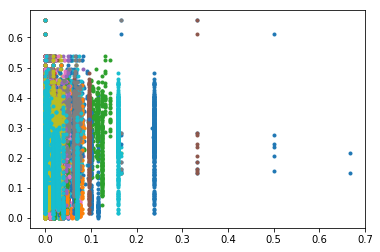

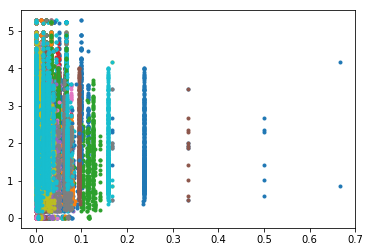

In [39]:
for target in targets:
    plt.figure()
    for col in dihedral_features:
        plt.plot(df_train[col],df_train[target],'.')

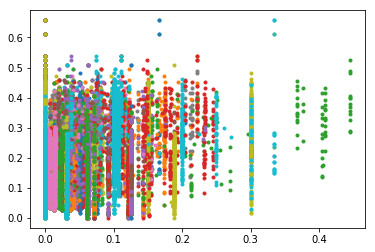

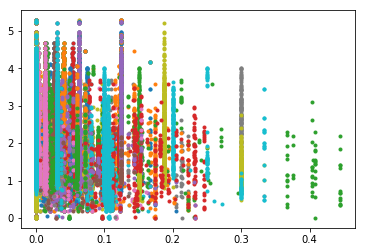

In [40]:
for target in targets:
    plt.figure()
    for col in angle_features:
        plt.plot(df_train[col],df_train[target],'.')

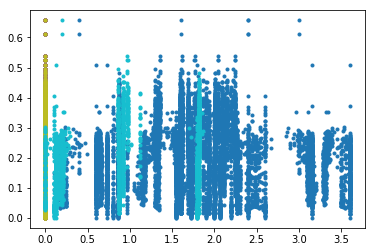

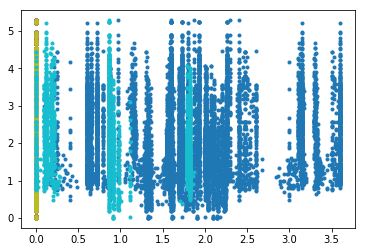

In [41]:
for target in targets:
    plt.figure()
    for col in path_features:
        plt.plot(df_train[col],df_train[target],'.')

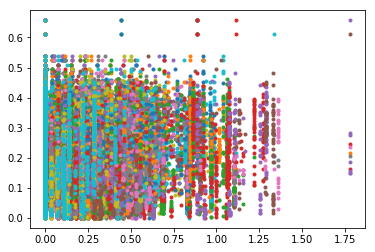

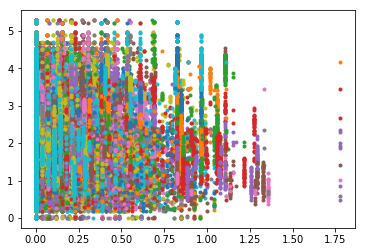

In [42]:
for target in targets:
    plt.figure()
    for col in dist_features:
        plt.plot(df_train[col],df_train[target],'.')

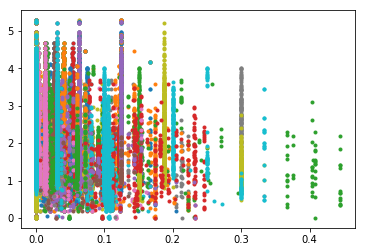

In [43]:
for col in angle_features:
    plt.plot(df_train[col],df_train['bandgap_energy_ev'],'.')

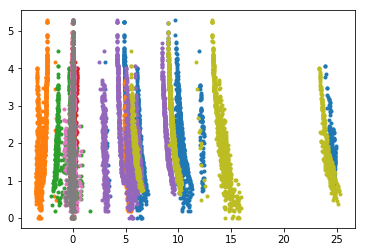

In [44]:
plt.plot(df_train[A_features],df_train['bandgap_energy_ev'],'.')

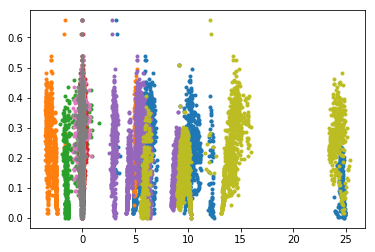

In [45]:
plt.plot(df_train[A_features],df_train['formation_energy_ev_natom'],'.')

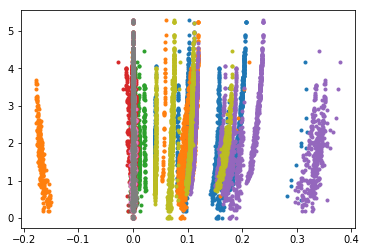

In [46]:
plt.plot(df_train[B_features],df_train['bandgap_energy_ev'],'.')

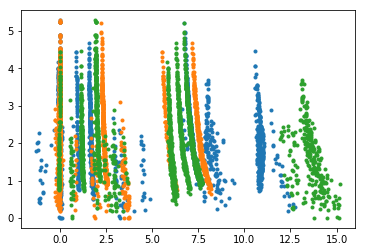

In [47]:
plt.plot(df_train[R_features],df_train['bandgap_energy_ev'],'.')

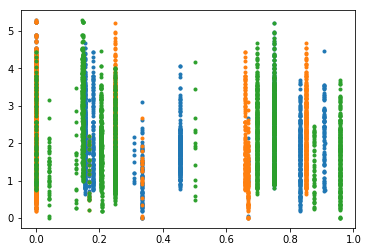

In [48]:
plt.plot(df_train[r_features],df_train['bandgap_energy_ev'],'.')

In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, ShuffleSplit,RandomizedSearchCV
from sklearn import metrics

In [50]:
def rmsle(h, y):
    return np.sqrt(np.square(np.log(h + 1) - np.log(y + 1)).mean())
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)

In [68]:
dist_features = [x for x in df_train.columns.tolist() if x.startswith('dist_')]
path_features = [x for x in df_train.columns.tolist() if x.startswith('path_')]
angle_features = [x for x in df_train.columns.tolist() if x.startswith('angle_')]
dihedral_features = [x for x in df_train.columns.tolist() if x.startswith('dihedral_')]
percent_features = [x for x in df_train.columns.tolist() if x.startswith('percent')]
avg_features = [x for x in df_train.columns.tolist() if x.startswith('avg')]
# dist_raw_features = [x for x in df_train.columns.tolist() if x.startswith('dist_raw_')]
# path_raw_features = [x for x in df_train.columns.tolist() if x.startswith('path_raw_')]
# angle_raw_features = [x for x in df_train.columns.tolist() if x.startswith('angle_raw_')]
# dihedral_raw_features = [x for x in df_train.columns.tolist() if x.startswith('dihedral_raw_')]

A_features = [x for x in df_train.columns.tolist() if x.startswith('A_')]
B_features = [x for x in df_train.columns.tolist() if x.startswith('B_')]
R_features = [x for x in df_train.columns.tolist() if x.startswith('R_')]
r_features = [x for x in df_train.columns.tolist() if x.startswith('r_')]

noatoms_features = [x for x in df_train.columns.tolist() if x.startswith('number_of_total_atoms_')]
spacegroup_features = [x for x in df_train.columns.tolist() if x.startswith('spacegroup_')]
lasd_features = [x for x in df_train.columns.tolist() if x.startswith('lattice_angle_sum_discrete_')]
clusters_features = [x for x in df_train.columns.tolist() if x.startswith('clusters_')]

In [92]:
clusters_features

['clusters_0',
 'clusters_1',
 'clusters_2',
 'clusters_3',
 'clusters_4',
 'clusters_5',
 'clusters_6',
 'clusters_7',
 'clusters_8',
 'clusters_9',
 'clusters_10']

formation_energy_ev_natom
Feature ranking:
1. feature avg_IP (0.552151)
2. feature avg_rd_max (0.300994)
3. feature avg_LUMO (0.055164)
4. feature avg_electronegativity (0.039247)
5. feature avg_rp_max (0.019017)
6. feature avg_EA (0.012259)
7. feature avg_mass (0.008237)
8. feature avg_rs_max (0.007114)
9. feature avg_HOMO (0.005817)


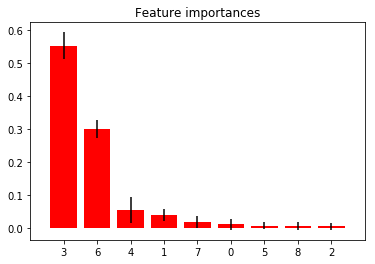

Feature ranking:
1. feature percent_atom_in (0.577689)
2. feature percent_atom_al (0.356644)
3. feature percent_atom_ga (0.065667)


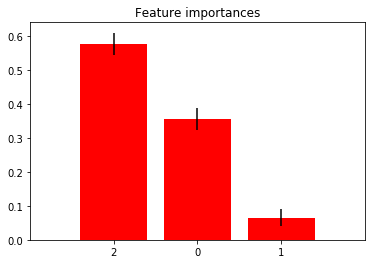

Feature ranking:
1. feature dist_25 (0.144464)
2. feature dist_16 (0.117227)
3. feature dist_23 (0.110953)
4. feature dist_46 (0.085615)
5. feature dist_33 (0.075813)
6. feature dist_15 (0.068542)
7. feature dist_40 (0.056873)
8. feature dist_8 (0.035513)
9. feature dist_18 (0.030295)
10. feature dist_77 (0.029814)
11. feature dist_29 (0.023200)
12. feature dist_49 (0.018533)
13. feature dist_65 (0.016057)
14. feature dist_48 (0.015243)
15. feature dist_20 (0.013700)
16. feature dist_47 (0.011626)
17. feature dist_30 (0.011327)
18. feature dist_39 (0.011031)
19. feature dist_57 (0.008829)
20. feature dist_34 (0.007985)
21. feature dist_42 (0.007552)
22. feature dist_35 (0.006038)
23. feature dist_9 (0.005198)
24. feature dist_31 (0.004959)
25. feature dist_64 (0.004619)
26. feature dist_56 (0.004526)
27. feature dist_37 (0.004388)
28. feature dist_19 (0.004345)
29. feature dist_27 (0.003982)
30. feature dist_24 (0.003853)
31. feature dist_44 (0.003504)
32. feature dist_75 (0.003344)
33

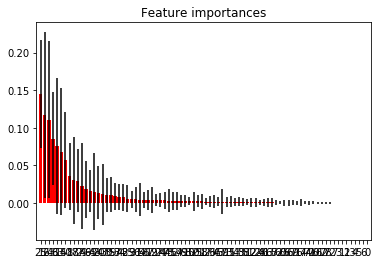

Feature ranking:
1. feature path_30 (0.411905)
2. feature path_20 (0.250948)
3. feature path_10 (0.225121)
4. feature path_0 (0.066520)
5. feature path_40 (0.024365)
6. feature path_49 (0.021141)
7. feature path_43 (0.000000)
8. feature path_42 (0.000000)
9. feature path_19 (0.000000)
10. feature path_18 (0.000000)
11. feature path_17 (0.000000)
12. feature path_16 (0.000000)
13. feature path_15 (0.000000)
14. feature path_14 (0.000000)
15. feature path_13 (0.000000)
16. feature path_12 (0.000000)
17. feature path_11 (0.000000)
18. feature path_47 (0.000000)
19. feature path_9 (0.000000)
20. feature path_8 (0.000000)
21. feature path_7 (0.000000)
22. feature path_6 (0.000000)
23. feature path_5 (0.000000)
24. feature path_4 (0.000000)
25. feature path_3 (0.000000)
26. feature path_2 (0.000000)
27. feature path_1 (0.000000)
28. feature path_46 (0.000000)
29. feature path_21 (0.000000)
30. feature path_22 (0.000000)
31. feature path_33 (0.000000)
32. feature path_41 (0.000000)
33. featur

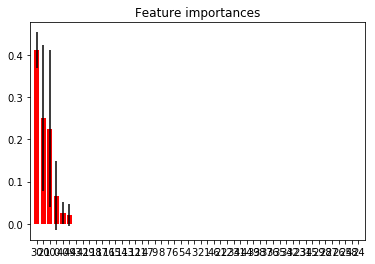

Feature ranking:
1. feature angle_179 (0.683039)
2. feature angle_86 (0.048421)
3. feature angle_169 (0.043775)
4. feature angle_95 (0.030458)
5. feature angle_171 (0.028901)
6. feature angle_93 (0.021587)
7. feature angle_121 (0.016461)
8. feature angle_89 (0.014317)
9. feature angle_108 (0.011820)
10. feature angle_165 (0.010309)
11. feature angle_91 (0.009731)
12. feature angle_119 (0.008852)
13. feature angle_122 (0.008390)
14. feature angle_123 (0.006853)
15. feature angle_131 (0.006043)
16. feature angle_176 (0.005172)
17. feature angle_85 (0.004820)
18. feature angle_111 (0.004346)
19. feature angle_160 (0.003729)
20. feature angle_120 (0.003164)
21. feature angle_109 (0.002609)
22. feature angle_162 (0.002222)
23. feature angle_74 (0.002051)
24. feature angle_112 (0.001739)
25. feature angle_82 (0.001739)
26. feature angle_92 (0.001680)
27. feature angle_172 (0.001640)
28. feature angle_84 (0.001617)
29. feature angle_80 (0.001389)
30. feature angle_118 (0.001216)
31. feature a

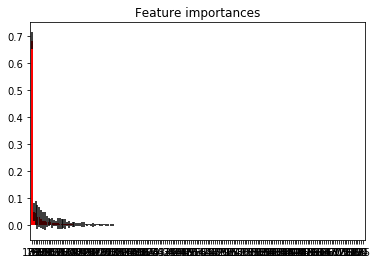

Feature ranking:
1. feature dihedral_75 (0.206160)
2. feature dihedral_154 (0.130107)
3. feature dihedral_178 (0.074601)
4. feature dihedral_66 (0.074206)
5. feature dihedral_7 (0.073819)
6. feature dihedral_97 (0.063943)
7. feature dihedral_131 (0.049280)
8. feature dihedral_85 (0.042134)
9. feature dihedral_24 (0.036327)
10. feature dihedral_179 (0.028868)
11. feature dihedral_79 (0.018234)
12. feature dihedral_135 (0.016685)
13. feature dihedral_177 (0.015452)
14. feature dihedral_169 (0.009400)
15. feature dihedral_91 (0.009204)
16. feature dihedral_119 (0.008773)
17. feature dihedral_46 (0.008620)
18. feature dihedral_76 (0.006569)
19. feature dihedral_86 (0.006394)
20. feature dihedral_2 (0.005837)
21. feature dihedral_27 (0.005695)
22. feature dihedral_60 (0.005671)
23. feature dihedral_25 (0.005621)
24. feature dihedral_88 (0.005280)
25. feature dihedral_0 (0.004099)
26. feature dihedral_20 (0.003960)
27. feature dihedral_59 (0.003245)
28. feature dihedral_174 (0.003241)
29. fe

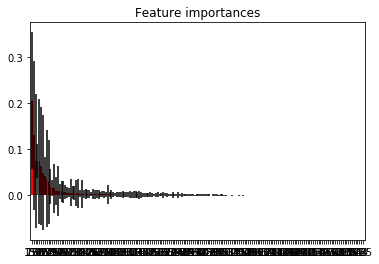

Feature ranking:
1. feature A_8 (0.565965)
2. feature A_5 (0.132542)
3. feature A_3 (0.057454)
4. feature A_2 (0.052691)
5. feature A_7 (0.046594)
6. feature A_0 (0.043548)
7. feature A_1 (0.038274)
8. feature A_6 (0.036602)
9. feature A_4 (0.026330)


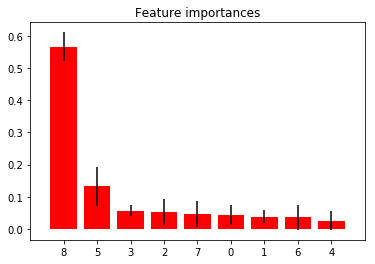

Feature ranking:
1. feature B_8 (0.608768)
2. feature B_6 (0.082947)
3. feature B_5 (0.082219)
4. feature B_2 (0.047653)
5. feature B_1 (0.043033)
6. feature B_3 (0.036340)
7. feature B_7 (0.035748)
8. feature B_0 (0.035584)
9. feature B_4 (0.027708)


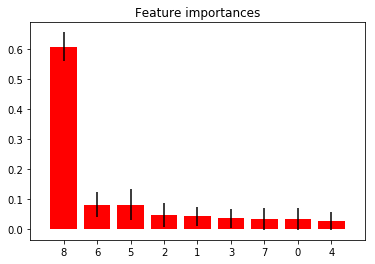

Feature ranking:
1. feature R_1 (0.585599)
2. feature R_2 (0.267888)
3. feature R_0 (0.146513)


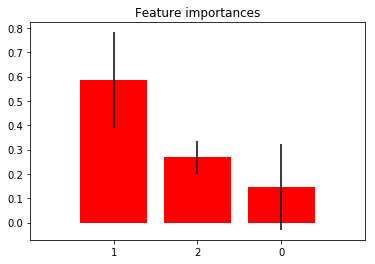

Feature ranking:
1. feature r_2 (0.650743)
2. feature r_1 (0.265617)
3. feature r_0 (0.083640)


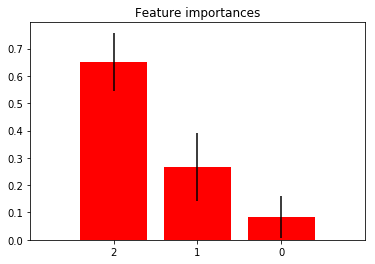

Feature ranking:
1. feature number_of_total_atoms_40.0 (0.754531)
2. feature number_of_total_atoms_80.0 (0.172959)
3. feature number_of_total_atoms_10.0 (0.058137)
4. feature number_of_total_atoms_20.0 (0.008480)
5. feature number_of_total_atoms_30.0 (0.005492)
6. feature number_of_total_atoms_60.0 (0.000401)


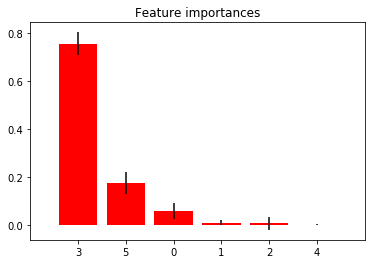

Feature ranking:
1. feature spacegroup_227 (0.501432)
2. feature spacegroup_194 (0.450886)
3. feature spacegroup_33 (0.036038)
4. feature spacegroup_206 (0.006312)
5. feature spacegroup_12 (0.005176)
6. feature spacegroup_167 (0.000156)


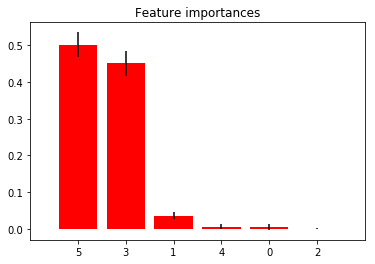

Feature ranking:
1. feature lattice_angle_sum_discrete_300 (0.358558)
2. feature lattice_angle_sum_discrete_215 (0.345573)
3. feature lattice_angle_sum_discrete_270 (0.162873)
4. feature lattice_angle_sum_discrete_285 (0.132996)


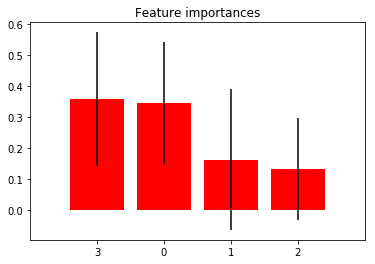

Feature ranking:
1. feature clusters_9 (0.329659)
2. feature clusters_1 (0.323712)
3. feature clusters_2 (0.303062)
4. feature clusters_0 (0.038307)
5. feature clusters_10 (0.004971)
6. feature clusters_8 (0.000289)
7. feature clusters_7 (0.000000)
8. feature clusters_6 (0.000000)
9. feature clusters_5 (0.000000)
10. feature clusters_4 (0.000000)
11. feature clusters_3 (0.000000)


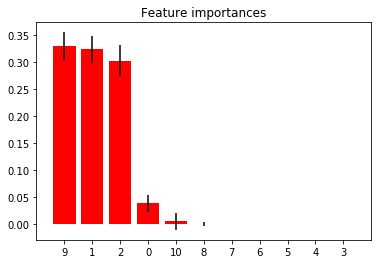

bandgap_energy_ev
Feature ranking:
1. feature avg_HOMO (0.618439)
2. feature avg_mass (0.352217)
3. feature avg_IP (0.011160)
4. feature avg_rd_max (0.005790)
5. feature avg_electronegativity (0.004417)
6. feature avg_rp_max (0.003308)
7. feature avg_EA (0.002298)
8. feature avg_rs_max (0.001248)
9. feature avg_LUMO (0.001123)


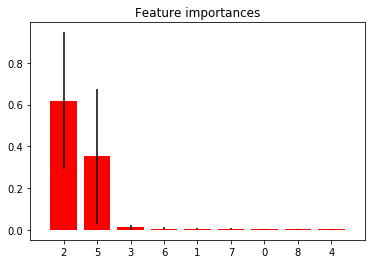

Feature ranking:
1. feature percent_atom_in (0.774719)
2. feature percent_atom_al (0.209192)
3. feature percent_atom_ga (0.016089)


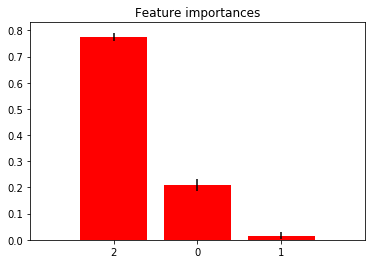

Feature ranking:
1. feature dist_16 (0.670917)
2. feature dist_17 (0.080499)
3. feature dist_21 (0.039711)
4. feature dist_11 (0.033762)
5. feature dist_15 (0.033217)
6. feature dist_18 (0.026068)
7. feature dist_42 (0.025008)
8. feature dist_8 (0.012733)
9. feature dist_19 (0.011221)
10. feature dist_35 (0.010042)
11. feature dist_7 (0.009048)
12. feature dist_9 (0.008342)
13. feature dist_12 (0.008046)
14. feature dist_10 (0.004029)
15. feature dist_71 (0.002596)
16. feature dist_52 (0.002418)
17. feature dist_14 (0.002364)
18. feature dist_22 (0.001886)
19. feature dist_40 (0.001382)
20. feature dist_57 (0.001129)
21. feature dist_43 (0.001083)
22. feature dist_31 (0.000884)
23. feature dist_13 (0.000830)
24. feature dist_30 (0.000810)
25. feature dist_44 (0.000753)
26. feature dist_23 (0.000732)
27. feature dist_59 (0.000709)
28. feature dist_34 (0.000631)
29. feature dist_28 (0.000616)
30. feature dist_46 (0.000604)
31. feature dist_51 (0.000571)
32. feature dist_24 (0.000500)
33.

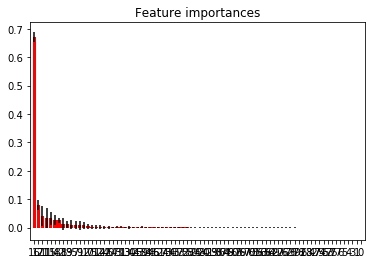

Feature ranking:
1. feature path_20 (0.341318)
2. feature path_40 (0.190699)
3. feature path_0 (0.174479)
4. feature path_30 (0.114859)
5. feature path_49 (0.097156)
6. feature path_10 (0.081488)
7. feature path_21 (0.000000)
8. feature path_19 (0.000000)
9. feature path_18 (0.000000)
10. feature path_17 (0.000000)
11. feature path_16 (0.000000)
12. feature path_15 (0.000000)
13. feature path_14 (0.000000)
14. feature path_13 (0.000000)
15. feature path_12 (0.000000)
16. feature path_11 (0.000000)
17. feature path_44 (0.000000)
18. feature path_9 (0.000000)
19. feature path_8 (0.000000)
20. feature path_7 (0.000000)
21. feature path_6 (0.000000)
22. feature path_5 (0.000000)
23. feature path_4 (0.000000)
24. feature path_3 (0.000000)
25. feature path_2 (0.000000)
26. feature path_1 (0.000000)
27. feature path_47 (0.000000)
28. feature path_22 (0.000000)
29. feature path_43 (0.000000)
30. feature path_23 (0.000000)
31. feature path_42 (0.000000)
32. feature path_41 (0.000000)
33. featur

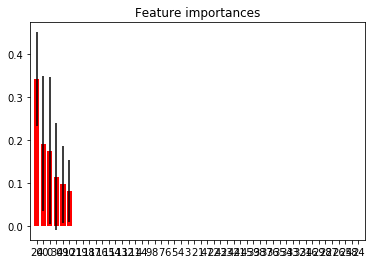

Feature ranking:
1. feature angle_84 (0.341221)
2. feature angle_95 (0.088670)
3. feature angle_102 (0.074036)
4. feature angle_118 (0.073853)
5. feature angle_123 (0.067554)
6. feature angle_78 (0.055717)
7. feature angle_126 (0.049837)
8. feature angle_97 (0.045905)
9. feature angle_86 (0.029485)
10. feature angle_94 (0.028359)
11. feature angle_101 (0.026209)
12. feature angle_169 (0.016694)
13. feature angle_179 (0.012263)
14. feature angle_82 (0.008123)
15. feature angle_80 (0.007712)
16. feature angle_125 (0.006896)
17. feature angle_91 (0.006519)
18. feature angle_81 (0.006453)
19. feature angle_98 (0.006042)
20. feature angle_119 (0.004897)
21. feature angle_90 (0.003612)
22. feature angle_162 (0.003145)
23. feature angle_161 (0.003143)
24. feature angle_89 (0.002805)
25. feature angle_106 (0.002748)
26. feature angle_85 (0.002725)
27. feature angle_108 (0.002346)
28. feature angle_92 (0.002028)
29. feature angle_107 (0.001995)
30. feature angle_96 (0.001697)
31. feature angle_

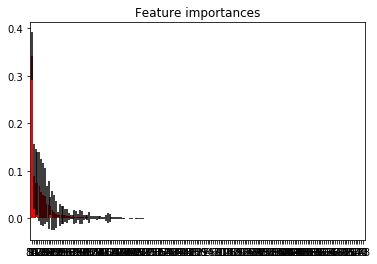

Feature ranking:
1. feature dihedral_39 (0.281370)
2. feature dihedral_48 (0.076385)
3. feature dihedral_118 (0.069745)
4. feature dihedral_130 (0.068042)
5. feature dihedral_49 (0.052502)
6. feature dihedral_89 (0.051232)
7. feature dihedral_129 (0.034301)
8. feature dihedral_76 (0.027490)
9. feature dihedral_40 (0.025100)
10. feature dihedral_2 (0.020902)
11. feature dihedral_99 (0.020249)
12. feature dihedral_79 (0.019364)
13. feature dihedral_29 (0.015076)
14. feature dihedral_132 (0.013977)
15. feature dihedral_61 (0.013759)
16. feature dihedral_135 (0.011058)
17. feature dihedral_74 (0.010003)
18. feature dihedral_64 (0.009635)
19. feature dihedral_20 (0.009527)
20. feature dihedral_52 (0.009140)
21. feature dihedral_25 (0.008776)
22. feature dihedral_114 (0.008405)
23. feature dihedral_133 (0.008066)
24. feature dihedral_107 (0.007879)
25. feature dihedral_134 (0.007580)
26. feature dihedral_17 (0.006363)
27. feature dihedral_102 (0.005982)
28. feature dihedral_9 (0.005423)
29. 

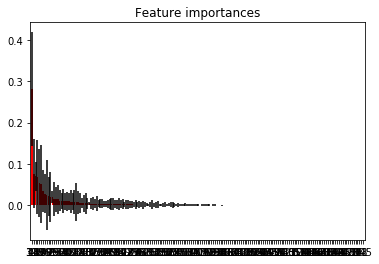

Feature ranking:
1. feature A_8 (0.346561)
2. feature A_0 (0.286297)
3. feature A_2 (0.160678)
4. feature A_4 (0.089760)
5. feature A_1 (0.070613)
6. feature A_7 (0.022190)
7. feature A_5 (0.020937)
8. feature A_6 (0.002076)
9. feature A_3 (0.000887)


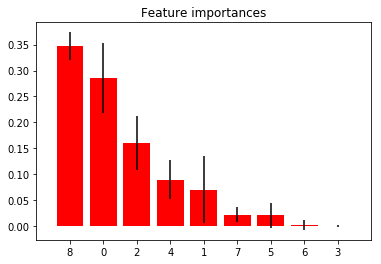

Feature ranking:
1. feature B_8 (0.387647)
2. feature B_0 (0.364353)
3. feature B_4 (0.071189)
4. feature B_2 (0.061590)
5. feature B_3 (0.045007)
6. feature B_1 (0.041785)
7. feature B_6 (0.012409)
8. feature B_5 (0.008715)
9. feature B_7 (0.007305)


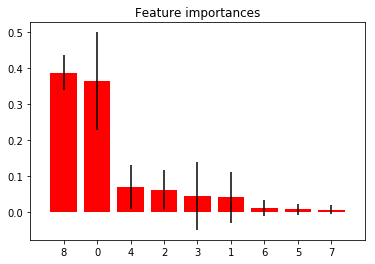

Feature ranking:
1. feature R_2 (0.454249)
2. feature R_1 (0.448592)
3. feature R_0 (0.097159)


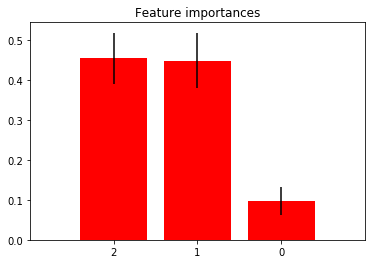

Feature ranking:
1. feature r_2 (0.774290)
2. feature r_0 (0.117172)
3. feature r_1 (0.108539)


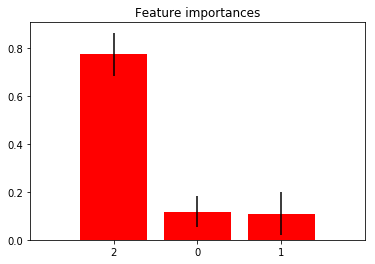

Feature ranking:
1. feature number_of_total_atoms_30.0 (0.666685)
2. feature number_of_total_atoms_40.0 (0.279548)
3. feature number_of_total_atoms_60.0 (0.022790)
4. feature number_of_total_atoms_80.0 (0.021890)
5. feature number_of_total_atoms_20.0 (0.004952)
6. feature number_of_total_atoms_10.0 (0.004135)


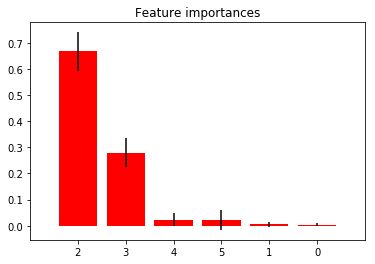

Feature ranking:
1. feature spacegroup_167 (0.566589)
2. feature spacegroup_227 (0.318410)
3. feature spacegroup_194 (0.095961)
4. feature spacegroup_12 (0.016426)
5. feature spacegroup_33 (0.002517)
6. feature spacegroup_206 (0.000097)


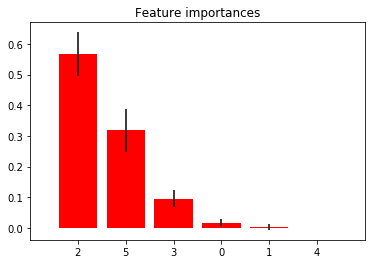

Feature ranking:
1. feature lattice_angle_sum_discrete_215 (0.843015)
2. feature lattice_angle_sum_discrete_270 (0.107125)
3. feature lattice_angle_sum_discrete_285 (0.039310)
4. feature lattice_angle_sum_discrete_300 (0.010550)


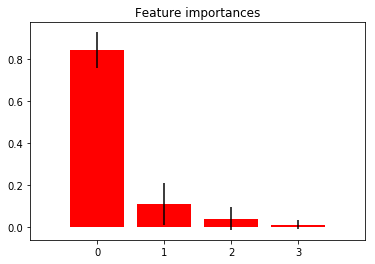

Feature ranking:
1. feature clusters_3 (0.515388)
2. feature clusters_9 (0.289858)
3. feature clusters_2 (0.099975)
4. feature clusters_1 (0.087451)
5. feature clusters_0 (0.003606)
6. feature clusters_6 (0.002415)
7. feature clusters_4 (0.001307)
8. feature clusters_10 (0.000000)
9. feature clusters_8 (0.000000)
10. feature clusters_7 (0.000000)
11. feature clusters_5 (0.000000)


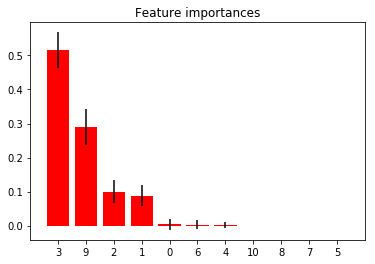

In [93]:
graph_features = ['avg_features','percent_features', 'dist_features' , 'path_features' , 'angle_features', 'dihedral_features', 'A', 'B', 'R', 'r', 'noatoms_features', 'spacegroup_features','lasd_features','clusters_features' ]
feature_dict={}
modelbased_corr_df = pd.DataFrame(data=np.zeros((len(targets),14)), columns=graph_features, index=targets)
reg0 = RandomForestRegressor(n_estimators=150, max_depth=4, n_jobs=-1)
for target in targets:
    print(target)
    y = np.log(df_train[target].values+1)
    features_next=[]
    for graph_feature in graph_features:
        if graph_feature == 'dist_features':
            features = dist_features
        elif graph_feature == 'path_features':
            features = path_features
        elif graph_feature == 'avg_features':
            features = avg_features
        elif graph_feature == 'percent_features':
            features = percent_features
        elif graph_feature == 'angle_features':
            features = angle_features
        elif graph_feature == 'dihedral_features':
            features = dihedral_features
        elif graph_feature == 'A':
            features = A_features
        elif graph_feature == 'B':
            features = B_features
        elif graph_feature == 'R':
            features = R_features
        elif graph_feature == 'r':
            features = r_features
        elif graph_feature == 'noatoms_features':
            features = noatoms_features
        elif graph_feature == 'spacegroup_features':
            features = spacegroup_features
        elif graph_feature == 'lasd_features':
            features = lasd_features
        elif graph_feature == 'clusters_features':
            features = clusters_features
        X = df_train[features].values
        score = cross_val_score(reg0, X, y, scoring=rmsle_scorer, cv=ShuffleSplit(n_splits= 5, test_size=.2))
        modelbased_corr_df.loc[target, graph_feature] = round(np.mean(score),3)
        reg = RandomForestRegressor(n_estimators=150, max_depth=4, n_jobs=-1)
        reg.fit(X,y)
        importances = reg.feature_importances_
        std = np.std([tree.feature_importances_ for tree in reg.estimators_],axis=0)
        indices = np.argsort(importances)[::-1]
        print("Feature ranking:")

        for f in range(X.shape[1]):
            print("%d. feature %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))
            if importances[indices[f]]>0.01:
                features_next.append(features[indices[f]])
                
        # Plot the feature importances of the forest
        plt.figure()
        plt.title("Feature importances")
        plt.bar(range(X.shape[1]), importances[indices],
               color="r", yerr=std[indices], align="center")
        plt.xticks(range(X.shape[1]), indices)
        plt.xlim([-1, X.shape[1]])
        plt.show()
    feature_dict[target]=features_next


In [72]:
modelbased_corr_df

,avg_features,percent_features,dist_features,path_features,angle_features,dihedral_features,A,B,R,r,noatoms_features,spacegroup_features,lasd_features,clusters_features
formation_energy_ev_natom,-0.055,-0.054,-0.046,-0.056,-0.049,-0.050,-0.045,-0.044,-0.051,-0.058,-0.069,-0.060,-0.067,-0.060
bandgap_energy_ev,-0.086,-0.083,-0.073,-0.144,-0.120,-0.114,-0.088,-0.093,-0.109,-0.147,-0.156,-0.152,-0.166,-0.148


In [ ]:
avg_features+percent_features+dist_features+A_features+B_features

In [73]:
len(feature_dict['bandgap_energy_ev'])

88

In [74]:
feature_dict['bandgap_energy_ev']

['avg_HOMO',
 'avg_mass',
 'avg_IP',
 'percent_atom_in',
 'percent_atom_al',
 'percent_atom_ga',
 'dist_16',
 'dist_17',
 'dist_21',
 'dist_11',
 'dist_15',
 'dist_18',
 'dist_42',
 'dist_19',
 'dist_8',
 'dist_9',
 'path_20',
 'path_40',
 'path_0',
 'path_49',
 'path_30',
 'path_10',
 'angle_84',
 'angle_95',
 'angle_123',
 'angle_118',
 'angle_102',
 'angle_78',
 'angle_126',
 'angle_97',
 'angle_94',
 'angle_86',
 'angle_101',
 'angle_169',
 'dihedral_39',
 'dihedral_130',
 'dihedral_48',
 'dihedral_118',
 'dihedral_89',
 'dihedral_49',
 'dihedral_129',
 'dihedral_76',
 'dihedral_40',
 'dihedral_79',
 'dihedral_29',
 'dihedral_99',
 'dihedral_134',
 'dihedral_2',
 'dihedral_132',
 'dihedral_135',
 'dihedral_20',
 'dihedral_114',
 'dihedral_74',
 'dihedral_107',
 'A_8',
 'A_0',
 'A_2',
 'A_4',
 'A_1',
 'A_5',
 'A_7',
 'B_0',
 'B_8',
 'B_4',
 'B_2',
 'B_1',
 'B_3',
 'R_2',
 'R_1',
 'R_0',
 'r_2',
 'r_0',
 'r_1',
 'number_of_total_atoms_30.0',
 'number_of_total_atoms_40.0',
 'number_of

In [75]:
len(feature_dict['formation_energy_ev_natom'])

94

In [89]:
df_train[df_train['clusters']==0][avg_features+percent_features+dist_features+A_features]

,avg_EA,avg_electronegativity,avg_HOMO,avg_IP,avg_LUMO,avg_mass,avg_rd_max,avg_rp_max,avg_rs_max,percent_atom_al,...,dist_79,A_0,A_1,A_2,A_3,A_4,A_5,A_6,A_7,A_8
0,-0.200725,1.685000,-2.710125,-5.794325,0.278750,43.009587,2.753750,1.436250,1.077500,0.6250,...,0.0,9.952088,0.040316,0.031640,-0.047248,8.551175,0.009666,-0.034658,-0.009534,9.177439
20,-0.235850,1.791250,-2.764500,-5.642700,0.483125,97.907375,2.022500,1.367500,1.052500,0.0000,...,0.0,10.937457,0.025825,0.059887,-0.030570,9.324760,0.042322,-0.065354,-0.039636,9.946031
37,-0.282162,1.728750,-2.753563,-5.630763,0.557500,84.550668,2.319375,1.420625,1.096250,0.3125,...,0.0,10.791446,0.015646,0.050270,-0.018635,9.200221,0.036782,-0.054927,-0.034824,9.826804
41,-0.260429,1.642633,-2.711412,-5.742720,0.411615,42.032429,2.897295,1.477364,1.119271,0.8125,...,0.0,10.037818,0.025496,0.028123,-0.029950,8.607578,0.011736,-0.030863,-0.011766,9.238437
42,-0.270998,1.674686,-2.728003,-5.697786,0.472997,58.513248,2.678114,1.456878,1.111880,0.6250,...,0.0,10.333429,0.021149,0.036597,-0.024947,8.839653,0.021533,-0.040072,-0.020797,9.469015
47,-0.245448,1.678436,-2.721503,-5.732886,0.402372,52.876373,2.705614,1.449378,1.099380,0.6250,...,0.0,10.194759,0.028119,0.034795,-0.033056,8.734752,0.017217,-0.038103,-0.016701,9.362987
57,-0.139400,1.783125,-2.730875,-5.795875,0.195062,67.198755,2.265000,1.355000,1.013750,0.1250,...,0.0,10.255040,0.053118,0.047929,-0.062290,8.802888,0.020688,-0.052324,-0.019280,9.421217
61,-0.243663,1.672954,-2.718510,-5.739901,0.392100,50.124393,2.741924,1.452671,1.100519,0.6562,...,0.0,10.145491,0.028843,0.033382,-0.033890,8.696073,0.015585,-0.036568,-0.015196,9.324558
64,-0.135887,1.772500,-2.725438,-5.811038,0.174625,61.708976,2.338125,1.361875,1.016250,0.1875,...,0.0,10.156503,0.054567,0.045104,-0.063958,8.725530,0.017422,-0.049255,-0.016270,9.344357
66,-0.262362,1.709375,-2.739438,-5.678638,0.481312,70.752673,2.479375,1.430625,1.095000,0.4375,...,0.0,10.525037,0.022029,0.043719,-0.026026,8.993053,0.028093,-0.047804,-0.026756,9.620072


In [91]:
X = df_train[df_train['clusters']==0][avg_features+percent_features+dist_features+A_features].values
y = np.log(df_train[df_train['clusters']==0]['formation_energy_ev_natom'].values+1)

svr = RandomizedSearchCV(RandomForestRegressor(criterion='mse',n_jobs=-1), cv=ShuffleSplit(n_splits=5, test_size=.2),
                       param_distributions={
                           'n_estimators':np.linspace(200,250,10,dtype='int'),
                           'max_depth':np.linspace(1,5,1,dtype='int'),
                           'min_samples_split':np.linspace(0.1,.8,10),
                           'min_samples_leaf':np.linspace(0.05,0.5,10),
                           'min_weight_fraction_leaf':np.linspace(0,0.41,10),
                           'max_leaf_nodes':np.linspace(2,5,1,dtype='int'),
                           'min_impurity_decrease':np.linspace(0,.001,2)},
                      n_iter = 250,
                      n_jobs=-1,
                      scoring=rmsle_scorer,
                )
svr.fit(X, y)
svr.best_params_,svr.best_score_

({'max_depth': 1,
  'max_leaf_nodes': 2,
  'min_impurity_decrease': 0.001,
  'min_samples_leaf': 0.15000000000000002,
  'min_samples_split': 0.41111111111111109,
  'min_weight_fraction_leaf': 0.27333333333333332,
  'n_estimators': 216},
 -0.031402521982668061)

In [78]:
X.shape

(2400, 94)

Feature ranking:
1. feature angle_179 (0.388626)
2. feature B_8 (0.341232)
3. feature A_8 (0.270142)
4. feature clusters_0 (0.000000)
5. feature angle_95 (0.000000)
6. feature path_20 (0.000000)
7. feature path_10 (0.000000)
8. feature path_0 (0.000000)
9. feature path_40 (0.000000)
10. feature path_49 (0.000000)
11. feature angle_86 (0.000000)
12. feature angle_169 (0.000000)
13. feature angle_171 (0.000000)
14. feature dihedral_97 (0.000000)
15. feature angle_121 (0.000000)
16. feature angle_93 (0.000000)
17. feature angle_89 (0.000000)
18. feature angle_108 (0.000000)
19. feature angle_165 (0.000000)
20. feature dihedral_75 (0.000000)
21. feature dihedral_7 (0.000000)
22. feature dihedral_154 (0.000000)
23. feature dihedral_178 (0.000000)
24. feature path_30 (0.000000)
25. feature dist_48 (0.000000)
26. feature dist_20 (0.000000)
27. feature dist_23 (0.000000)
28. feature avg_rd_max (0.000000)
29. feature avg_LUMO (0.000000)
30. feature avg_electronegativity (0.000000)
31. feature a

IndexError: index 30 is out of bounds for axis 1 with size 11

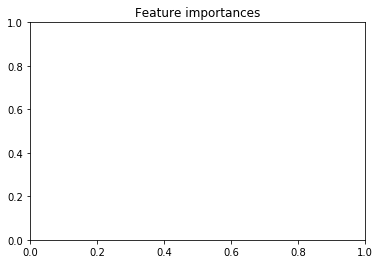

In [79]:
importances = svr.best_estimator_.feature_importances_

std = np.std([tree.feature_importances_ for tree in reg.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, feature_dict['formation_energy_ev_natom'][indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [ ]:
importances